    简历过滤器

用提供的数据集训练一个模型，用来过滤求职者的简历；
用来判断求职者是：不能被录取、适合当开发工程师、适合当测试工程师，还是适合当经理
验证标准：精准率，召回率和 F1Score。

1.尝试使用 sklearn 的 逻辑回归模型，SVM模型，以及 高斯贝叶斯模型，决策树
2.自己实现逻辑回归，SVM，以及朴素贝叶斯


In [15]:
import numpy as np
import pandas as pd
import re
import math

#数据归一化处理
def data_nomalization(x):
    std = np.std(x,axis=0) #标准差
    mean = np.mean(x,axis=0) #均值
    return ((x-mean)/std,mean,std)
    
# 数据处理
def data_handle():
    csv_data = pd.read_csv("employees_dataset.csv")
    # 将学历数值化。1:本科 2：硕士 3:博士 0：其它
    csv_data["degree_cleaned"] = np.where(csv_data["degree"] == "bachelor", 1,
                                          np.where(csv_data["degree"] == 'master', 2,
                                                   np.where(csv_data["degree"] == "phd", 3, 0)))

    # 读取世界前500名校，用于做学校清洗，是世界前500标记为1，不是标记为0
    # 学校排名数据从网上爬下来的
    famous_school_data = pd.read_csv("school.csv")
    school_name_list = famous_school_data["1"]
    school_name_list = np.array(school_name_list[1:], dtype="str")
    lower_name_list = [item.lower() for item in school_name_list]
    edulist = np.array(csv_data["education"])
    edu_cleaned_list = []
    for edu in edulist:
        if edu in lower_name_list:
            edu_cleaned_list.append(1)
        else:
            edu_cleaned_list.append(0)
    csv_data["education_cleaned"] = edu_cleaned_list

    # 技能清洗，用16bit表示16种技能，每一位代表一种技能，有则为1，无则为0
    skill_clean_ret = skill_clean(np.array(csv_data["skills"]))
    csv_data["skill_cleaned"] = skill_clean_ret

    #职位清洗
    csv_data["position_cleaned"] = np.where(csv_data["position"] == "dev",1,
                                               np.where(csv_data["position"] == "manager",2,3))
    return csv_data
    

def skill_clean(skills_list):
    skill_filter = ["c", "c++", "java,j2ee", "ios,objective-c,swift", "sql,database", "python", "linux",
                    "software engineering,project management", "team building", "customer service",
                    "test management,test plan", "test,test automation", "qtp", "quality assurance", "shell,script"]
    skill_clean_ret = []
    for skills in skills_list:
        ret = 0
        skill_list = skills.split(";")
        # 取前5种技能
        skill_list = skill_list[:5]
        for skill in skill_list:
            skill = skill.replace('+', '\+')
            for index, k in enumerate(skill_filter):
                if re.search(skill, k) != None:
                    ret += int(math.pow(2, index+1))
                    break
        skill_clean_ret.append(np.log2(ret+1)) #取2为底的对数，降低数据集。效果会比不取对数好很多
    return skill_clean_ret


# 使用LogisticRegression

In [16]:
#逻辑回归
from sklearn.linear_model import LogisticRegression

def logic_predict(train_x,train_y,test_x,test_y):
    classifier = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
    classifier.fit(X=train_x,y=train_y.astype(int))
    y_predict = classifier.predict(test_x)

    print("=== 逻辑回归 =====")
    judge_model(test_y,y_predict)



# 使用SVC

In [17]:
# 使用SVM
from sklearn import svm
from sklearn.svm import SVC


def svm_predict(train_x, train_y, test_x, test_y):
    print("====== SVC =====")
    clf = SVC(gamma='auto', C=1, decision_function_shape='ovo')
    clf.fit(train_x, train_y.astype(int))
    print("====== 测试集 =====")
    predict_y = clf.predict(test_x)
    judge_model(test_y, predict_y)
    print("====== 训练集 =====")
    predict_y = clf.predict(train_x)
    judge_model(train_y, predict_y)

# 使用贝叶斯

In [18]:
#使用高斯贝叶斯
from sklearn.naive_bayes import GaussianNB
def bayes_predict(train_x, train_y, test_x, test_y):
    gsnb = GaussianNB()
    gsnb.fit(train_x,train_y.astype(int))
    predict_y = gsnb.predict(test_x)
    print("=== 高斯贝叶斯 ====")
    judge_model(test_y,predict_y)

# 模型验证

In [19]:
# 根据精准率，召回率，FlScore评判模型
def judge_model(real, predict):
    # 正确率只是想计算一下看下
    correct_num = np.sum((real-predict) == 0)
    total = np.size(predict, axis=0)
    rate = correct_num/total
    print(("正确率为:"+repr(rate)))

    print('=======')
    print("实际值：")
    print(real)
    print("预测值：")
    print(predict)
    # 从real中获取测试的所有类的取值
    class_list = set(real)
    print('=======')
    print(("预测的类别有："+repr(class_list)))

    # 计算每个类的精准率，召回率，FlScore
    for c in class_list:
        n_pred_c = np.sum(predict == c)
        n_real_c = np.sum(real == c)
        c_list = np.array([c]*total)
        TP = np.sum((predict == c_list) & (
            real == c_list) == True)  # 实际为c类，预测也为c类
        #FP = np.sum(predict == c ) -TP  #实际不是c类，但被预测为c类
#         FN = np.sum( real == c ) - TP #实际是c类，但被预测为其它类
        print(("TP:"+str(TP)+",pred_c:"+str(n_pred_c)+",real_c:"+str(n_real_c)))

        # 精准率
        precision = recall = flscore = 0
        if n_pred_c != 0:
            precision = TP/n_pred_c
        else:
            precision = 0
        # 召回率
        if n_real_c != 0:
            recall = float(TP)/n_real_c
        else:
            recall = 0

        if (precision + recall) != 0:
            flscore = 2*(precision * recall)/(precision + recall)
        else:
            flscore = 0

        print(("预测"+repr(c)+":"))
        print(("精准率："+str(precision)+",召回率：" +
               str(recall)+",flscore:"+repr(flscore)))

In [20]:

from sklearn.model_selection import train_test_split
import time
import matplotlib as plt
def main():
    data = data_handle()
    #将数据分为训练集和测试集
    #train,test = train_test_split(data,test_size=0.1,random_state=int(time.time()))
    
        #因为样本不均匀，随机抽取可能会使某一类不在训练集或全在训练集，所以手动选择
    test = data[::6]
    train = data.append(test).drop_duplicates(keep = False)

    train = np.array(train)
    train_x = train[:,5:8]
    train_y = train[:,8]
    
    test = np.array(test)
    test_x = test[:,5:8]
    test_y = test[:,8]


    logic_predict(train_x,train_y,test_x,test_y)
    svm_predict(train_x,train_y,test_x,test_y)

    bayes_predict(train_x,train_y,test_x,test_y)

    

    
main()

=== 逻辑回归 =====
正确率为:0.6666666666666666
实际值：
[1 1 1 1 1 1 1 1 2 2 2 3]
预测值：
[1 1 1 2 1 2 1 1 2 1 2 2]
预测的类别有：{1, 2, 3}
TP:6,pred_c:7,real_c:8
预测1:
精准率：0.8571428571428571,召回率：0.75,flscore:0.7999999999999999
TP:2,pred_c:5,real_c:3
预测2:
精准率：0.4,召回率：0.6666666666666666,flscore:0.5
TP:0,pred_c:0,real_c:1
预测3:
精准率：0,召回率：0.0,flscore:0
====== SVC =====
====== 测试集 =====
正确率为:0.75
实际值：
[1 1 1 1 1 1 1 1 2 2 2 3]
预测值：
[1 1 1 1 1 2 1 1 3 1 2 3]
预测的类别有：{1, 2, 3}
TP:7,pred_c:8,real_c:8
预测1:
精准率：0.875,召回率：0.875,flscore:0.875
TP:1,pred_c:2,real_c:3
预测2:
精准率：0.5,召回率：0.3333333333333333,flscore:0.4
TP:1,pred_c:2,real_c:1
预测3:
精准率：0.5,召回率：1.0,flscore:0.6666666666666666
====== 训练集 =====
正确率为:0.8666666666666667
实际值：
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3]
预测值：
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 3 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 3 3 3 1 1 3 1]
预测的类别有：{1, 2, 3}
TP:34,pred_c:39,real_c:37
预测1:


# 自己编写逻辑回归

训练集的大小:61
测试集的大小:11
=== 逻辑回归 =====
正确率为:0.7272727272727273
实际值：
[1 1 1 1 1 1 1 2 2 2 3]
预测值：
[1 1 1 1 1 1 1 1 1 2 2]
预测的类别有：{1, 2, 3}
TP:7,pred_c:9,real_c:7
预测1:
精准率：0.7777777777777778,召回率：1.0,flscore:0.8750000000000001
TP:1,pred_c:2,real_c:3
预测2:
精准率：0.5,召回率：0.3333333333333333,flscore:0.4
TP:0,pred_c:0,real_c:1
预测3:
精准率：0,召回率：0.0,flscore:0
 ===== 开始 训练 ====== 
(61, 7)
(7,)
[0. 0. 0. 0. 0. 0. 0.]
最终得到的theta为：array([ 2.70624142e-04, -3.26531035e-01, -1.94051969e-01, -1.40964975e+00,
        7.47952655e-02,  2.62301630e-01,  4.05328320e-01])
1的最终的损失为:0.4985696814176488
==== end  ======== 
(7,)
[0. 0. 0. 0. 0. 0. 0.]
最终得到的theta为：array([-4.17354935e-04,  2.51900671e-01,  8.58543212e-02,  1.22508662e+00,
       -1.00263001e-03, -7.00288113e-01, -7.00551872e-01])
2的最终的损失为:0.4575282335037266
==== end  ======== 
(7,)
[0. 0. 0. 0. 0. 0. 0.]
最终得到的theta为：array([-9.31564581e-04, -3.49978623e-01,  1.12247952e-01,  7.37721044e-01,
       -8.70904772e-01,  1.04799090e-01, -1.52331369e+00])
3的最终的损失为:0

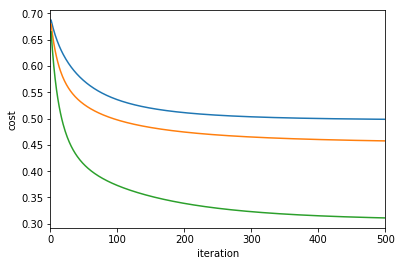

In [21]:
# 自己实现逻辑回归

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time

# 定义梯度下降
# X_set 变量集
# y_set 结果集
# alpha 学习速率


def gradient_descent(X_set, y_set, alpha, theta,lamda):
    #print("==== 梯度 下降 ===== ")
    m = np.size(X_set, axis=0)
    regular_theta = theta
    regular_theta[0] = 0
    h_x =1/(1+np.e** -np.dot(X_set , theta))
    derivative_sum = np.dot(X_set.transpose(), h_x - y_set)
    theta = theta - alpha*(derivative_sum/m + (lamda/m)*regular_theta)
    #theta = theta - alpha * derivative_sum/m
    return theta

# 定义代价函数


def cost_function(X_set, y, theta,lamda):
   # print("==== 代价函数  计算损失==== ")
    #cost = -1/m(sum(ylog(h(x) + (1-y)log(1-h(x)))))
    m = np.size(X_set, axis=0)  # 样本个数
    h_x =1/(1+np.e** -np.dot(X_set , theta))
    regular_theta  = theta.copy()
    regular_theta[0] = 0
    cost = np.sum (y*np.log(h_x) + (1-y)*np.log(1-h_x))/-m+(lamda/(2*m))*np.sum(np.square(regular_theta))
    #cost = np.sum (y*np.log(h_x) + (1-y)*np.log(1-h_x))/-m
    return cost

# 定义训练方法
def train(X_train, y_train):
    print(" ===== 开始 训练 ====== ")
    

    #增加多项式
    x3s = X_train[:,2]*X_train[:,2]
    x1s = X_train[:,0]*X_train[:,0]
    x2s = X_train[:,1]*X_train[:,1]


    X_train = np.hstack((X_train,x1s.reshape(-1,1)))
    X_train = np.hstack((X_train,x3s.reshape(-1,1)))
    X_train = np.hstack((X_train,x2s.reshape(-1,1)))


    # 初始化第0列全为1，作为theta_0的变量
    X_train = np.insert(X_train, 0, 1, axis=1)
    dimention = np.size(X_train, axis=1)  # X的维度
    print(X_train.shape)
    
    #获取所有y的取值,然后将y的结果集拆分成n个结果集，每个结果集判断一种y的取值，是为1，不是为0
    y_set = set(y_train)
    
    theta_dict  = {}
    for y in y_set :
        y_train_new = np.where (y_train== y , 1 , 0)
        theta = np.zeros(dimention) # 初始化theta变量全为0
        print(theta.shape)
        print(theta)
        
        #训练单个分类模型
        theta = sub_train ( X_train , y_train_new,theta,y)
        theta_dict[y] = theta
    return theta_dict
        
def sub_train ( X_train, y_train , theta,y) :
        num_iters = 500  # 迭代次数
        alpha = 0.05
        cost_plot = list()
        iteration = range(1, num_iters)
        lamda = 0.0     
        for i in iteration:
            theta = gradient_descent(X_train, y_train, alpha, theta,lamda)
            # 计算损失
            cost = cost_function(X_train, y_train, theta,lamda)
            cost_plot.append(cost)
            #print("第"+repr(i)+"迭代之后的 损失为：" + repr(cost))

    # 画出损失函数图
        plt.xlim(0, num_iters)
        plt.plot(iteration, cost_plot)
        plt.xlabel("iteration")
        plt.ylabel("cost")
    
        print ( "最终得到的theta为："+ repr(theta))
        print (repr(y)+"的最终的损失为:"+repr(cost))
        print("==== end  ======== ")
        return theta
    
#预测
def predicate ( X_set , theta_dict) :
    m = np.size(X_set, axis=0)  # 样本个数
    x3s = X_set[:,2]*X_set[:,2]
    x1s = X_set[:,0]*X_set[:,0]
    x2s = X_set[:,1]*X_set[:,1]
    X_set = np.hstack((X_set,x1s.reshape(-1,1)))
    X_set = np.hstack((X_set,x3s.reshape(-1,1)))
    X_set = np.hstack((X_set,x2s.reshape(-1,1)))


    X_set = np.insert ( X_set , 0 , 1 , axis = 1)
    
    last_y_pred = np.zeros(m) #默认初始化预测值为0
    #循环遍历每个取值的概率模型，取取值最大的那个，再判断最大的那个的概率是否大于0.5
    #这里是假定取值y_key 为整数
    for y_key in theta_dict :
        theta = theta_dict.get(y_key)
        y_pred = 1 / (1 + np.e ** -np.dot(X_set, theta))
        cost = cost_function(X_set,y_pred,theta,0.0)
        print("类%d的损失为：%.4f" %(y_key ,cost))
        last_y_pred = np.where(y_pred > (last_y_pred-last_y_pred.astype(int)) , y_key + y_pred,last_y_pred)
    last_y_pred = np.where ( last_y_pred - last_y_pred.astype(int) > 0.5, last_y_pred.astype(int), 0)
    
    
    return last_y_pred
    
# 定义主函数
def my_main():
    data = data_handle()
     # 将数据分为训练集和测试集
#     train_set, test_set  = train_test_split(
#         data, test_size=0.1, random_state=int(time.time()))
    #因为样本不均匀，随机抽取可能会使某一类不在训练集或全在训练集，所以手动选择
    test_set = data[::7]
    train_set = data.append(test_set).drop_duplicates(keep = False)
    

    train_set = np.array(train_set)
    train_X = train_set [:, 5:8]
    train_y = train_set [:, 8]

    test_set = np.array(test_set)
    test_X = test_set[:, 5:8]
    test_y = test_set[:, 8]
    
    print("训练集的大小:"+repr(np.size(train_X,axis=0)))
    print("测试集的大小:"+repr(np.size(test_X,axis=0)))
    logic_predict(train_X,train_y,test_X,test_y)
    
    train_X,mean,std = data_nomalization(train_X.astype(float))
    test_X = (test_X - std)/mean

    theta = train (train_X.astype(float) , train_y)
    
    print("========训练集验证 ：=======")
    y_pred = predicate(train_X.astype(float) , theta)
    judge_model (train_y , y_pred )

    
    print("======= 测试集验证 ：======")
    y_pred = predicate(test_X.astype(float) , theta)
    judge_model (test_y , y_pred )
    

    
    
my_main ( )

# 自己实现贝叶斯


In [22]:
# 自己实现贝叶斯分类模型
# 假设P(Xi|C) 符合高斯分布


def bayes_train(X_train, y_train):
    print("==== bayes  train =======")
    # 由贝叶斯的似然函数可知道，假设k个类C，特征值X有n个，则theta矩阵为 k*n或n*k
    # 因为为高斯分布，所以每一个theta有两个参数值 u和sigma^2

    class_y = set(y_train)  # 统计分类
    class_cnt = len(class_y)  # 分类的个数
    feature_cnt = np.size(X_train, axis=1)  # X的维度即特征值的个数
    
    m = np.size ( X_train , axis=0) #样本个数
    print("样本总个数:"+repr(m))
    class_theta_map = {} #类与theta参数的对应关系
    class_p_map = {}  #类的概率
    for y in class_y:
        sample_rows = np.where(y_train==y)  # 返回y_train结果集中为y类的行号

        # 根据行号取出对应的特征集
        X_sample = X_train[sample_rows]
        mc = np.size(X_sample, axis=0)

        # 求均值
        oneclass_mean_matrix = np.sum(X_sample, axis=0)/mc  # 得到一个类别在各个特征值上的均值


        # 求sigma^2
        oneclass_sigma_square_matrix = np.sum(
            np.square(X_sample - oneclass_mean_matrix), axis=0)/mc
        #合并两个参数 得到一个类似[[std_1,sigma_1],[std_2,sigma_2] ...]
        oneclass_theta = np.array(np.vstack((oneclass_mean_matrix,oneclass_sigma_square_matrix)))
        class_theta_map [y] = oneclass_theta
        
        P_c = mc / m #C类出现的概率
        class_p_map[y] = P_c
        
    return class_theta_map,class_p_map

#预测
def predicate(X_set , class_theta_map , class_p_map) :
    print("===== 预测  ====== ")
    m = np.size(X_set, axis=0)
    result = pd.DataFrame(np.zeros((m,2)),columns=["p","class"]) #初始
    #循环计算每个类的概率,去掉1/Z
    
    print(class_p_map)
    for c in class_theta_map :
        P_c = class_p_map[c]
        theta = class_theta_map[c]
        mean = theta[0]
        sigma_square = theta[1]
        sigma = np.sqrt(sigma_square)
        const_num = np.sqrt(2*np.pi)
        #print(const_num)
        P_x_c = np.prod ((1/(const_num*sigma))*(np.e ** -np.square(X_set - mean)/(2*sigma_square)),axis=1)
        #print(P_x_c)
        P_c_x = P_c*P_x_c.astype(float)
     
        result["class"] = np.where(result["p"] < P_c_x, c, result["class"]).astype(int)
        result["p"] = np.where(result["p"] < P_c_x, P_c_x, result["p"]) #取概率大的那个
    return np.array(result["class"].astype(int) )    
       
        
        
        
        
# 定义主函数
def bayes_main():
    data = data_handle()
    # 将数据分为训练集和测试集
      #因为样本不均匀，随机抽取可能会使某一类不在训练集或全在训练集，所以手动选择
    test_set = data[::7]
    train_set = data.append(test_set).drop_duplicates(keep = False)

    train_set = np.array(train_set)
    train_X = train_set [:, 5:8]
    train_y = train_set [:, 8]

    test_set = np.array(test_set)
    test_X = test_set[:, 5:8]
    test_y = test_set[:, 8]
    
    bayes_predict(train_X,train_y,test_X,test_y)
    
    theta,class_p = bayes_train (train_X.astype(float) , train_y)
    
    print("训练集验证 ：")
    y_pred = predicate(train_X , theta,class_p)
    judge_model (train_y , y_pred )
    
    print("测试集验证 ：")
    y_pred = predicate(test_X , theta,class_p)
    judge_model (test_y , y_pred )
    
    
bayes_main ( )        
    
    
    
        
        

=== 高斯贝叶斯 ====
正确率为:1.0
实际值：
[1 1 1 1 1 1 1 2 2 2 3]
预测值：
[1 1 1 1 1 1 1 2 2 2 3]
预测的类别有：{1, 2, 3}
TP:7,pred_c:7,real_c:7
预测1:
精准率：1.0,召回率：1.0,flscore:1.0
TP:3,pred_c:3,real_c:3
预测2:
精准率：1.0,召回率：1.0,flscore:1.0
TP:1,pred_c:1,real_c:1
预测3:
精准率：1.0,召回率：1.0,flscore:1.0
==== bayes  train =======
样本总个数:61
训练集验证 ：
===== 预测  ====== 
{1: 0.6229508196721312, 2: 0.26229508196721313, 3: 0.11475409836065574}
正确率为:0.6721311475409836
实际值：
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3]
预测值：
[1 2 1 1 1 2 2 1 1 2 1 1 1 2 1 3 1 1 2 1 2 1 1 2 2 2 2 3 1 1 2 1 1 1 2 1 1
 1 1 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 2 1 2]
预测的类别有：{1, 2, 3}
TP:23,pred_c:25,real_c:38
预测1:
精准率：0.92,召回率：0.6052631578947368,flscore:0.7301587301587301
TP:14,pred_c:29,real_c:16
预测2:
精准率：0.4827586206896552,召回率：0.875,flscore:0.6222222222222222
TP:4,pred_c:7,real_c:7
预测3:
精准率：0.5714285714285714,召回率：0.5714285714285714,flscore:0.5714285714285714
测试集验证 ：
===== 预测 

# 自己实现SVM

In [31]:
import matplotlib.pyplot as plt
import matplotlib

# 单个子SVM
class SubSVM:
    # 成员变量
    w = 0  # 最大超平面的w向量值
    b = 0  # 最大超平面的b值
    category = 0
    # 构造函数，初始化，传入类别

    def __init__(self, category):
        self.category = category
        matplotlib.use('TkAgg')

    # 训练
    def train(self, X_train, y_train):
        m = np.size(X_train, axis=0)  # 样本个数
        # 使用SMO算法最优化对偶问题，求得最优的alpha
        C = 1.0
        max_iter = 100
        optimize_alpha,b = self.smo_simple(X_train, y_train, C, max_iter)
        # 求w
        self.w = np.dot(X_train.transpose(), optimize_alpha*y_train)
        # 求b，由KKT条件得：(1-y(wx+b)) = 0。求所有支持向量的均值
        self.b = np.sum(y_train - np.dot(X_train, self.w))/m
        print("==== w === ")
        print(self.w)
        print("====== b :"+repr(self.b))

    # SMO算法
    def smo_simple(self, X_train, y_train, C, max_iter):
        print("====== SMO ===== ")
        m, n = X_train.shape
        #alpha = np.zeros(m).astype(float)  # 初始化alpha
        alpha = np.ones(m)
        b = 0
        iters = 0
        cost_plot = list()
        iteration = range(1,max_iter+1)
        while iters < max_iter:
            iters += 1
            for i in range(0, m):
                # 求f(xi)的值
                fxi = np.sum(alpha * y_train *
                             np.dot(X_train, X_train[i].transpose()))+b
                # 求实际值与预测值之间的差
                Ei = fxi - y_train[i]

                # 随机选取第二个参数j， j!=i
                j = self.select_j_rand(i, m)
                fxj = np.sum(alpha * y_train *
                             np.dot(X_train, X_train[j].transpose()))+b
                Ej = fxj - y_train[j]

                # Kii+Kjj-2Kij
                eta = np.dot(X_train[i], X_train[i].transpose())+np.dot(X_train[j],
                                                                        X_train[j].transpose()) - 2*np.dot(X_train[i], X_train[j].transpose())
                
                if(eta == 0) :
                    continue
                alpha_j_new = (
                    y_train[j]*(Ei - Ej))/eta + alpha[j]
                
                alpha_i_old = alpha[i].copy()
                alpha_j_old = alpha[j].copy()
                
                # 根据约束条件裁剪alpha_j_new
                alpha_j_new,L,H = self.clipped_alpha(
                    alpha_j_new, y_train[i], y_train[j], alpha[i], alpha[j], C)
                if ( L == H ) :
                  #  print("第"+repr(iters)+"次循环:L=H="+repr(L)+",i="+repr(i))
                    continue
        
          
      
                alpha[j] = alpha_j_new
        
                if(abs(alpha_j_new - alpha_j_old) < 0.0001) :
                    #print("第"+repr(iters)+"次循环,改变很小，无需优化"+repr(j))
                    continue
                # 根据alpha_j 求alpha_i
                alpha_i_new = alpha[i] + (alpha_j_old - alpha_j_new)*y_train[i]*y_train[j]

              # 更新alpha
                alpha[i] = alpha_i_new
                

                # 更新b
                b1 = (alpha_i_old-alpha[i])*y_train[i]*np.dot(X_train[i], X_train[i].transpose())+(
                    alpha_j_old-alpha[j])*y_train[j] * np.dot(X_train[j], X_train[i].transpose())+b-Ei

                b2 = (alpha_i_old-alpha[i])*y_train[i]*np.dot(X_train[i], X_train[j].transpose())+(
                    alpha_j_old-alpha[j])*y_train[j] * np.dot(X_train[j], X_train[j].transpose())+b-Ej

                if 0< alpha[i] and C > alpha[i]:
                    b = b1
                elif 0< alpha[j] and C > alpha[j]:
                    b = b2
                else:
                    b = (b1+b2)/2
            #计算损失
            cost = self.cost_function(X_train,y_train,b,alpha)
            cost_plot.append(cost)
        print("==== 最终损失为："+repr(cost))
        # 画出损失函数图
        plt.xlim(0, max_iter)
        plt.plot(iteration,cost_plot)
        plt.xlabel("iteration")
        plt.ylabel("cost")

    
        return alpha,b

    # 随机选择第二个参数的index j
    def select_j_rand(self, i, m):
        j = i
        while (j == i):
            j = random.randint(0, m-1)
        return j

    # 裁剪alpha
    def clipped_alpha(self, alpha_new_x, yi, yj, alpha_i, alpha_j, C):
        L = H = 0
        if yi != yj:           
            k = alpha_j - alpha_i
            # 确定下界
            L = max(k, 0)
            # 确定上界
            H = min(C, C+k)
        else:
            k = alpha_i+alpha_j
            L = max(0, k - C)
            H = min(k, C)
        # alpha_new 必须介于L和H之间
        alpha_new_x = max(L, alpha_new_x)
        alpha_new_x = min(H, alpha_new_x)
                
        return alpha_new_x,L,H

    #计算损失
    def cost_function(self , X_train, y_train, b,alpha):
        m ,n = X_train.shape
        cost =  np.sum(np.square(np.dot( np.dot(X_train, X_train.transpose()), alpha*y_train) + b - y_train))/m
        return cost
        
    # 决策
    def sign(self, X):
        f_x =  np.dot(X, self.w) + self.b
        # 决策函数决策，返回1，0， -1 预测值。1 表示正类。即属于self.category
        sign_fx = np.where(f_x < 0, -1, np.where(f_x == 0, 0, 1))
        return sign_fx

====== SVC =====
====== 测试集 =====
正确率为:0.9090909090909091
实际值：
[1 1 1 1 1 1 1 2 2 2 3]
预测值：
[1 1 1 1 1 1 1 2 2 2 1]
预测的类别有：{1, 2, 3}
TP:7,pred_c:8,real_c:7
预测1:
精准率：0.875,召回率：1.0,flscore:0.9333333333333333
TP:3,pred_c:3,real_c:3
预测2:
精准率：1.0,召回率：1.0,flscore:1.0
TP:0,pred_c:0,real_c:1
预测3:
精准率：0,召回率：0.0,flscore:0
====== 训练集 =====
正确率为:0.8524590163934426
实际值：
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3]
预测值：
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 1
 1 1 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 1 1 1]
预测的类别有：{1, 2, 3}
TP:34,pred_c:38,real_c:38
预测1:
精准率：0.8947368421052632,召回率：0.8947368421052632,flscore:0.8947368421052632
TP:14,pred_c:18,real_c:16
预测2:
精准率：0.7777777777777778,召回率：0.875,flscore:0.823529411764706
TP:4,pred_c:5,real_c:7
预测3:
精准率：0.8,召回率：0.5714285714285714,flscore:0.6666666666666666
====== 自己写的 SVM ======
====== SMO ===== 
==== 最终损失为：103.9604234466903
==== w === 
[17.  

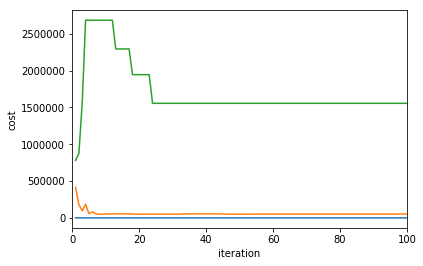

In [32]:
import random
# 线性可分SVM
class LinearSVM:
    model_list = list()  # 因为SVM是一个二分类，所以通过构造N-1个SubSVM来进行多分类

    # 训练
    def fit(self, X_train, y_train):
        m = np.size(X_train, axis=0)  # 样本个数
        # 获取所有y的取值,然后将y的结果集拆分成n个结果集，每个结果集判断一种y的取值，是为1，不是为-1
        y_set = set(y_train)
        for y in y_set:
            y_sub_train = np.where(y_train == y, 1, -1)
            subSVM = SubSVM(y)
            subSVM.train(X_train, y_sub_train)
            self.model_list.append(subSVM)

     # 预测

    def predict(self, X):
        m = np.size(X, axis=0)  # 样本个数
        y_pred = np.zeros(m)
        print("===== 预测 ====== ")
        # 让样本经过每一个模型进行预测
        need_pred_X = X
        result = pd.DataFrame(np.zeros((m,2)),columns=["p","class"]) #初始\
        unjudge_samples = np.array(range(0,m))
        for index, model in enumerate(self.model_list):
            
            print("==== 预测 :"+repr(model.category))
            sign_x = model.sign(need_pred_X)
#             result["class"] = np.where(result["p"] <= sign_x, model.category, result["class"])
#             result["p"] = np.where(result["p"] <= sign_x, sign_x, result["p"])
            
            if  index == (len(self.model_list) - 1):
                # 最后一个模型，无需再分类
                y_pred[unjudge_samples] = model.category
            else:
                negtive_columns=np.where(sign_x != 1)
                positive_columns=np.where(sign_x == 1)

                need_pred_X = X[negtive_columns]
                y_pred[unjudge_samples[positive_columns]] = model.category
                unjudge_samples = unjudge_samples[negtive_columns]
        return y_pred.astype(int)

def my_svm_main() :
    
    data = data_handle()
    # 将数据分为训练集和测试集
      #因为样本不均匀，随机抽取可能会使某一类不在训练集或全在训练集，所以手动选择
    test_set = data[::7]
    train_set = data.append(test_set).drop_duplicates(keep = False)

    train_set = np.array(train_set)
    train_X = train_set [:, 5:8]
    train_y = train_set [:, 8]

    test_set = np.array(test_set)
    test_X = test_set[:, 5:8]
    test_y = test_set[:, 8]
    
    svm_predict(train_X,train_y,test_X,test_y)
#     train_X,mean,std = data_nomalization(train_X.astype(float))
#     test_X = (test_X-mean)/std
      
    print("====== 自己写的 SVM ======")
    mysvm = LinearSVM()
    mysvm.fit(train_X.astype(float), train_y)
    
    print("=======训练集验证 ：======")
    
    y_pred = mysvm.predict(train_X)
    judge_model (train_y , y_pred )
    
    print("======= 测试集验证 ：=======")
    y_pred = mysvm.predict(test_X)
    judge_model (test_y , y_pred )
    
my_svm_main()

